In [103]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
import requests
import json
import folium
import statsmodels.api as sm
from patsy import dmatrices
import statsmodels.formula.api as smf
jtplot.style()

# Problem 1: Burglaries

A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents that were reported during the six month period from January 1, 2021 through June 30, 2021.

In [104]:
endpoint = "https://data.nashville.gov/resource/2u6v-ujjs.geojson?"
offset = 0
limit = 10000
burg = gpd.GeoDataFrame()
while True:
    params1 = {
        "offense_description":"BURGLARY- AGGRAVATED",
        #offense_nibrs":220,
        "$where":"incident_reported between '2021-01-01T00:00:00.000' and '2021-06-30T23:59:59.000'",
        "$offset":offset,
        "$limit":limit
    }
    res = requests.get(endpoint, params1)
    res_gdf = gpd.read_file(res.text)
    burg = gpd.GeoDataFrame(pd.concat([burg, res_gdf], ignore_index = True))
    
    if len(res_gdf) != limit:
        break
        
    offset += limit

burglary = burg.drop_duplicates(subset = 'incident_number')
burglary

victim_county_resident zip_code victim_number offense_nibrs   rpa  \
0                  RESIDENT     None             1           220  8203   
1                  RESIDENT     None             1           220  9615   
2              NON RESIDENT     None             1           220  6901   
3              NON RESIDENT     None             3           220  None   
5                  RESIDENT     None             2           220  8401   
...                     ...      ...           ...           ...   ...   
1046               RESIDENT    37013             1           220  8861   
1047               RESIDENT    37210             1           220  8201   
1048               RESIDENT    37207             1           220  3013   
1049                   None     None             1           220  8655   
1050               RESIDENT     None             1           220  1701   

     latitude victim_race incident_number investigation_status offense_number  \
0       36.15           B     20210249540                 Open              1   
1        36.2           W     20210248840                 Open              1   
2       36.14           W     20210244919                 Open              1   
3       36.14           W     20210244892                 Open              1   
5       36.11           W     20210248402                 Open              1   
...       ...         ...             ...                  ...            ...   
1046   36.052           B     20210029313               Closed              1   
1047   36.152           B     20210073787               Closed              1   
1048   36.204           B     20210127915               Closed              1   
1049    36.05        None     20210126551                 Open              1   
1050    36.27           B     20210257587                 Open              1   

      ... weapon_primary report_type_description  victim_type  \
0     ...             09              DISPATCHED            I   
1     ...             09              DISPATCHED            I   
2     ...             17              DISPATCHED            I   
3     ...             17              DISPATCHED            I   
5     ...             17              DISPATCHED            I   
...   ...            ...                     ...          ...   
1046  ...             01              DISPATCHED            I   
1047  ...             09              DISPATCHED            I   
1048  ...             17              DISPATCHED            I   
1049  ...             17                    None            B   
1050  ...             16              DISPATCHED            I   

     incident_status_code incident_status_description  zone victim_gender  \
0                       O                        OPEN   511             F   
1                       O                        OPEN   525             F   
2                       O                        OPEN   815             M   
3                       O                        OPEN  None             M   
5                       O                        OPEN   313             F   
...                   ...                         ...   ...           ...   
1046                    A           CLEARED BY ARREST   327             F   
1047                    A           CLEARED BY ARREST   511             F   
1048                    A           CLEARED BY ARREST   631             M   
1049                    O                        OPEN   827          None   
1050                    O                        OPEN   715             M   

        incident_occurred     primary_key                    geometry  
0     2021-05-04T23:45:00  20210249540_11  POINT (-86.77000 36.15000)  
1     2021-05-04T12:06:00  20210248840_11  POINT (-86.63000 36.20000)  
2     2021-05-01T23:00:00  20210244919_11  POINT (-86.78000 36.14000)  
3     2021-05-01T21:30:00  20210244892_13  POINT (-86.78000 36.14000)  
5     2021-05-04T00:00:00  20210248402_12  POINT (-86.73000 36.11000)  
...  

# Problem 2: Census Tract Shapefiles

Download the 2019 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred. Which census tract had the highest number of burglaries? Warning - each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents.

In [105]:
tn_shape = gpd.read_file("data/tl_2019_47_tract.shp").to_crs(crs = burglary.crs)

In [106]:
tn_shape.columns = tn_shape.columns.str.lower()

In [107]:
tn_shape = (tn_shape.rename(columns = {'statefp':'state',
                            'countyfp':'county',
                            'namelsad':'tract_name',
                            'tractce':'tract'}
                )
                #.drop(columns = ['name', 'namelsad'])
            )

In [108]:
tn_burglary = gpd.sjoin(burglary, tn_shape, op = 'within')

In [109]:
tn_burglary.value_counts('tract')

tract
016300    53
016200    21
011001    20
019500    19
019300    19
          ..
013602     1
018202     1
013202     1
017902     1
015627     1
Length: 148, dtype: int64

# Problem 3: Populations

For this part, you'll need to request a census API key. Using the 2019 American Community Survey API, obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37. Merge this new data with the burglaries data above.

In [110]:
with open('C:/Users/jrior/Documents/NSS/api_keys.json') as fi:
    credentials = json.load(fi)
    
api_key = credentials['census_data']

In [111]:
endpoint = "https://api.census.gov/data/2019/acs/acs5?"
query = f"get=NAME,B01001_001E&for=tract:*&in=state:47"#&key={api_key}"
response2 = requests.get(endpoint+query)
response2

<Response [200]>

In [112]:
res2_dict = response2.json()
tn_pops = pd.DataFrame().from_dict(res2_dict)
tn_pops.columns = tn_pops.loc[0]
tn_pops = (tn_pops.drop(tn_pops.index[0])
           .reset_index(drop = True)
           .rename(columns = {'NAME': 'name',
                              'B01001_001E': 'population'}
                  )
           .astype({'population':'int'})
          )

In [113]:
endpoint = "https://api.census.gov/data/2019/acs/acs5/subject?"
query = f"get=NAME,S1901_C01_012E&for=tract:*&in=state:47"#&key={api_key}"
response3 = requests.get(endpoint+query)
response3

<Response [200]>

In [114]:
res3_dict = response3.json()
tn_med_inc = pd.DataFrame().from_dict(res3_dict)
tn_med_inc.columns = tn_med_inc.loc[0]
tn_med_inc = (tn_med_inc.drop(tn_med_inc.index[0])
              .reset_index(drop = True)
              .rename(columns = {'NAME': 'name',
                                 'S1901_C01_012E': 'median_income'}
                     )
              .astype({'median_income':'int'})
             )

In [119]:
tn_med_inc

0                                                name  median_income state  \
0     Census Tract 156.31, Davidson County, Tennessee          75579    47   
1     Census Tract 158.04, Davidson County, Tennessee          45129    47   
2     Census Tract 177.01, Davidson County, Tennessee         134786    47   
3     Census Tract 177.02, Davidson County, Tennessee         107813    47   
4     Census Tract 183.01, Davidson County, Tennessee          87591    47   
...                                               ...            ...   ...   
1492      Census Tract 115, Bradley County, Tennessee          61488    47   
1493   Census Tract 112.01, Bradley County, Tennessee          57162    47   
1494      Census Tract 101, Bradley County, Tennessee          44396    47   
1495      Census Tract 105, Bradley County, Tennessee          38356    47   
1496      Census Tract 108, Bradley County, Tennessee          30933    47   

0    county   tract  
0       037  015631  
1       037  015804  
2       037  017701  
3       037  017702  
4       037  018301  
...     ...     ...  
1492    011  011500  
1493    011  011201  
1494    011  010100  
1495    011  010500  
1496    011  010800  

[1497 rows x 5 columns]

In [115]:
tn_census = tn_pops.merge(tn_med_inc)
tn_census[['county_name', 'state_name']] = (tn_census['name'].str.split(pat = ', ',
                                         expand = True
                                        )
                                       .drop(columns = [0])
    )
tn_census = tn_census.drop(columns = 'name')

In [116]:
tn = tn_census.merge(tn_burglary)

In [117]:
tn[tn['tract'] == '016300']

population state county   tract  median_income      county_name  \
358        2560    47    037  016300          50710  Davidson County   
359        2560    47    037  016300          50710  Davidson County   
360        2560    47    037  016300          50710  Davidson County   
361        2560    47    037  016300          50710  Davidson County   
362        2560    47    037  016300          50710  Davidson County   
363        2560    47    037  016300          50710  Davidson County   
364        2560    47    037  016300          50710  Davidson County   
365        2560    47    037  016300          50710  Davidson County   
366        2560    47    037  016300          50710  Davidson County   
367        2560    47    037  016300          50710  Davidson County   
368        2560    47    037  016300          50710  Davidson County   
369        2560    47    037  016300          50710  Davidson County   
370        2560    47    037  016300          50710  Davidson County   
371        2560    47    037  016300          50710  Davidson County   
372        2560    47    037  016300          50710  Davidson County   
373        2560    47    037  016300          50710  Davidson County   
374        2560    47    037  016300          50710  Davidson County   
375        2560    47    037  016300          50710  Davidson County   
376        2560    47    037  016300          50710  Davidson County   
377        2560    47    037  016300          50710  Davidson County   
378        2560    47    037  016300          50710  Davidson County   
379        2560    47    037  016300          50710  Davidson County   
380        2560    47    037  016300          50710  Davidson County   
381        2560    47    037  016300          50710  Davidson County   
382        2560    47    037  016300          50710  Davidson County   
383        2560    47    037  016300          50710  Davidson County   
384        2560    47    037  016300          50710  Davidson County   
385        2560    47    037  016300          50710  Davidson County   
386        2560    47    037  016300          50710  Davidson County   
387        2560    47    037  016300          50710  Davidson County   
388        2560    47    037  016300          50710  Davidson County   
389        2560    47    037  016300          50710  Davidson County   
390        2560    47    037  016300          50710  Davidson County   
391        2560    47    037  016300          50710  Davidson County   
392        2560    47    037  016300          50710  Davidson County   
393        2560    47    037  016300          50710  Davidson County   
394        2560    47    037  016300          50710  Davidson County   
395        2560    47    037  016300          50710  Davidson County   
396        2560    47    037  016300          50710  Davidson County   
397        2560    47    037  016300          50710  Davidson County   
398        2560    47    037  016300          50710  Davidson County   
399        2560    47    037  016300          50710  Davidson County   
400        2560    47    037  016300          50710  Davidson County   
401        2560    47    037  016300          50710  Davidson County   
402        2560    47    037  016300          50710  Davidson County   
403        2560    47    037  016300          50710  Davidson County   
404        2560    47    037  016300          50710  Davidson County   
405        2560    47    037  016300          50710  Davidson County   
406        2560    47    037  016300          50710  Davidson County   
407        2560    47    037  016300          50710  Davidson County   
408        2560    47    037  016300          50710  Davidson County   
409        2560    47    037  016300          50710  Davidson County   
410        2560    47    037  016300          50710  Davidson County   

    state_name victim_county_resident zip_code victim_number  ... index_right  \
358  Tennessee           NON RESIDE

In [118]:
tn.shape

(826, 48)

# Problem 4

Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

In [69]:
tract_burgs_counts = (tn_burglary.value_counts('tract')
              .reset_index()
              .rename(columns = {0:'burglary_count'})
              )


tract_burgs = (tract_burgs_counts.merge(tn_tracts[['tract','geometry']])
                                .merge(tn_burgs[['tract', 'population', 'median_income']].drop_duplicates())
              )
tract_burgs['burgs_per_1000'] = (tract_burgs['burglary_count'] * 1000) / tract_burgs['population']
tract_burgs = gpd.GeoDataFrame(tract_burgs, crs=tn_bur.crs)

In [70]:
tract_burgs = tract_burgs[tract_burgs['burgs_per_1000'] != np.inf]

In [71]:
tract_burgs.sort_values('burgs_per_1000', ascending = False)

tract  burglary_count  \
0    016300              53   
38   016000               7   
1    016200              21   
25   017200               9   
7    019300              19   
..      ...             ...   
168  015619               1   
170  010303               1   
181  017800               1   
190  018801               1   
196  018202               1   

                                              geometry  population  \
0    POLYGON ((-86.79426 36.13750, -86.79364 36.140...        2560   
38   POLYGON ((-86.77516 36.14917, -86.77503 36.149...         945   
1    POLYGON ((-86.78898 36.13514, -86.78896 36.135...        3074   
25   POLYGON ((-86.77457 36.11881, -86.77455 36.118...        1427   
7    POLYGON ((-86.78295 36.19177, -86.78274 36.191...        3428   
..                                                 ...         ...   
168  POLYGON ((-86.61091 36.12746, -86.61077 36.127...        5105   
170  POLYGON ((-85.17869 35.21511, -85.17869 35.215...        5105   
181  POLYGON ((-86.81208 36.10880, -86.81193 36.109...        5498   
190  POLYGON ((-86.77516 36.05341, -86.77516 36.053...        5889   
196  POLYGON ((-86.92488 36.09803, -86.92485 36.098...        7222   

     median_income  burgs_per_1000  
0            50710       20.703125  
38           37083        7.407407  
1            27174        6.831490  
25           53148        6.306938  
7            14277        5.542590  
..             ...             ...  
168          74335        0.195886  
170          53143        0.195886  
181          85189        0.181884  
190         101027        0.169808  
196          57500        0.138466  

[187 rows x 6 columns]

In [72]:
centroid163 = tract_burgs.loc[tract_burgs['tract'] == '016300', 'geometry'].centroid
centroid163

<ipython-input-72-1580195dadb1>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid163 = tract_burgs.loc[tract_burgs['tract'] == '016300', 'geometry'].centroid


0    POINT (-86.78991 36.14319)
dtype: geometry

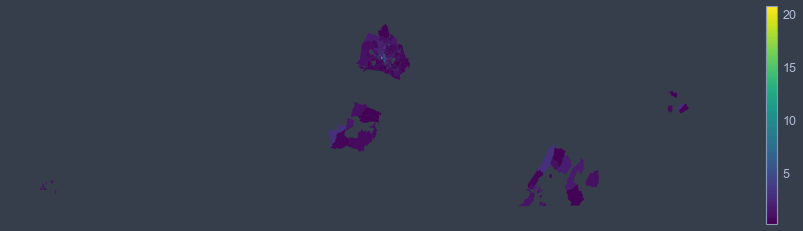

In [73]:
fig, ax = plt.subplots(figsize=(16,4))
tract_burgs.plot(column = 'burgs_per_1000',
                 legend = True,
                 ax = ax)
ax.axis('off');

In [74]:
m = folium.Map(location=[centroid163.y,centroid163.x], zoom_start=13)

folium.Choropleth(
    geo_data=tract_burgs,
    name="choropleth",
    data=tract_burgs,
    columns=["tract","burgs_per_1000"],
    key_on="feature.properties.tract",
    fill_color="Spectral",
    fill_opacity=0.7,
    line_opacity=.1,
    legend_name="Burglaries Per 1000 People",
).add_to(m)

folium.LayerControl().add_to(m)

m

# Problem 5

Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. For this, we'll be using the Generalized Linear Models module of the statsmodels library.

a. Build a "base model" - a Poisson regression model with just an intercept term with target variable the rate of burglaries per census tract. (Offset using the [log of the] population so that we are looking at the rate of burglaries per population instead of the number of burglaries.)

In [75]:
poisreg_burg_base = (sm.GLM(endog = tract_burgs['burgs_per_1000'],
                       exog = sm.add_constant(tract_burgs[[]]),
                       family = sm.families.Poisson(),
                       offset = np.log((1/1000)*tract_burgs['population'])
                      )
                  .fit()
               )

In [76]:
poisreg_burg_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         burgs_per_1000   No. Observations:                  187
Model:                            GLM   Df Residuals:                      186
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -353.87
Date:                Thu, 07 Oct 2021   Deviance:                       332.71
Time:                        19:29:22   Pearson chi2:                     975.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1517      0.062    -18.561      0.000      -1.273      -1.030
==============================================================================
"""

b. Now, build a Poisson regression model with target variable the rate of burglaries and predictor variable the median income. (Don't forget to offset by the population).

In [77]:
poisreg_burg_mi = (sm.GLM(endog = tract_burgs['burgs_per_1000'],
                       exog = sm.add_constant(tract_burgs['median_income']),
                       family = sm.families.Poisson(),
                       offset = np.log((1/1000)*tract_burgs['population'])
                      )
                  .fit()
               )

In [78]:
poisreg_burg_mi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         burgs_per_1000   No. Observations:                  187
Model:                            GLM   Df Residuals:                      185
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -353.87
Date:                Thu, 07 Oct 2021   Deviance:                       332.71
Time:                        19:29:22   Pearson chi2:                     975.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.1517      0.062    -18.542      0.000      -1.273      -1.030
median_income  5.475e-11   2.02e-09      0.027      0.978    -3.9e-09    4.01e-09
=================================================================================
"""

c. Finally, try out a negative binomial model. To get started with a negative binomial model, you can check out this tutorial.

d. How do your models compare? Hint: the fit models have an AIC attribute.

# Problem 6: Presentation